Tesk Task
https://docs.google.com/document/d/1hhTYiaOEef75Cbv7o-B8CjyqqFXyiUJJFcSk0GXwOhM/edit#

# Step 1

It is worth saying right away that I will import libraries immediately before use, it is more convenient for me this way at least in notebooks. There is a file requirements.txt to view all the necessary dependencies at once.   
To get started, we need to download the dataset. We will need authentication via kaggle.

In [1]:
import opendatasets as od

In [2]:
dataset_url = 'https://www.kaggle.com/alxmamaev/flowers-recognition'
od.download(dataset_url)

Skipping, found downloaded files in "./flowers-recognition" (use force=True to force download)


In [3]:
import os
from pathlib import Path

In [4]:
data_root_path = Path('./flowers-recognition/flowers')
classes = os.listdir(data_root_path)
CLASS_NUM = len(classes)
print(f'CLASS_NUM = {CLASS_NUM}')
classes

CLASS_NUM = 5


['tulip', 'rose', 'daisy', 'sunflower', 'dandelion']

The class names are listed above. Let's take a look at the size of the dataset and is it balanced by classes.

In [5]:
paths_dict = dict()
total_samples = 0
for cl in classes:
    paths_dict[cl] = list((data_root_path / cl).rglob('*.jpg'))
    total_samples += len(paths_dict[cl])

print(f'total_samples: {total_samples}')
ratios = sorted([(cl, len(paths_dict[cl]) / total_samples) for cl in classes],
                key=lambda x: x[1])
print('class ratios:\n' + '\n'.join([str(r) for r in ratios]))

print(f'max(ratio) / min(ratio) : {ratios[-1][1] / ratios[0][1]}')

total_samples: 4317
class ratios:
('sunflower', 0.16979383831364372)
('daisy', 0.17697475098447996)
('rose', 0.18160759786889044)
('tulip', 0.22793606671299513)
('dandelion', 0.24368774611999072)
max(ratio) / min(ratio) : 1.4351978171896316


## Do they have the same size and ratio?
No

## Is the dataset balanced?
pretty well balanced, but not perfect

## What features should be involved in a train-test split decision?
I don't really understand the question in terms of data with images, but in general, it depends on the target metric and the class distribution in the test dataset.
But, as a rule, it is better to use stratification, to preserve class distribution in each of the splits.  
However, for example, if metric aggregation strategy assumes that all classes are equaly important, it is better to use sampling with balancing adjusted probabilities for classes within a batch in training phase.

## Should you use a stratification for that?
In that case use stratification is not really necessary - dataset is pretty well balanced, but I will do it because I almost always do it, or something like that. Its application almost never makes results worse (if the test dataset was made correctly and is representative of train).

## Train-Val-Test split
There is no test dataset in this dataset, so we have to make it ourselves.
I will split data in 70-10-20 percents respectively.

Let's take a look at the first pictures of each class (if we consider the entire notebook as a pipeline, then this part is not realy needed)

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mimg

flowers-recognition/flowers/tulip/8708209606_d3aede4801.jpg
Shape: (333, 500, 3)


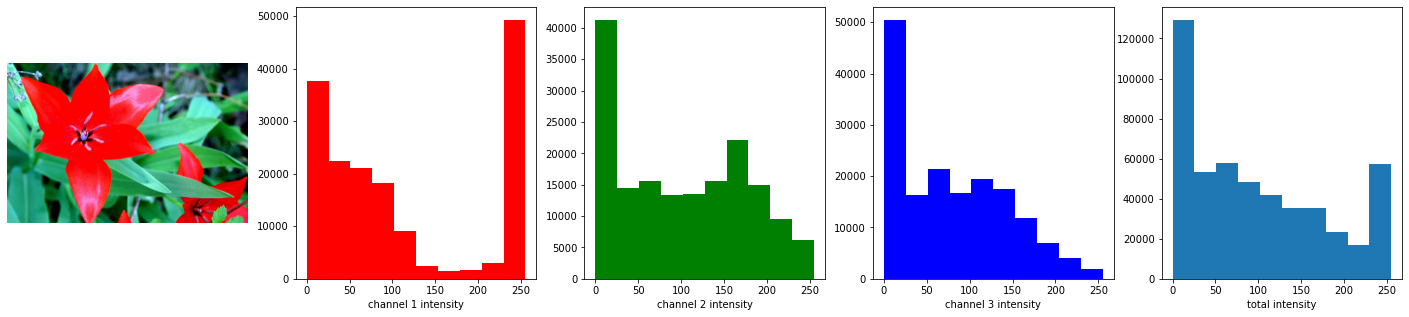

flowers-recognition/flowers/rose/2777518561_105abc8cfc_n.jpg
Shape: (240, 320, 3)


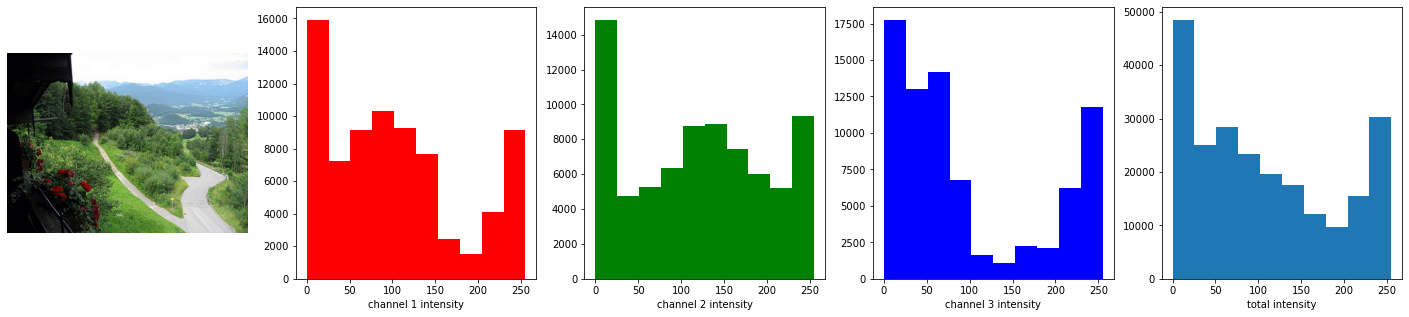

flowers-recognition/flowers/daisy/305160642_53cde0f44f.jpg
Shape: (375, 500, 3)


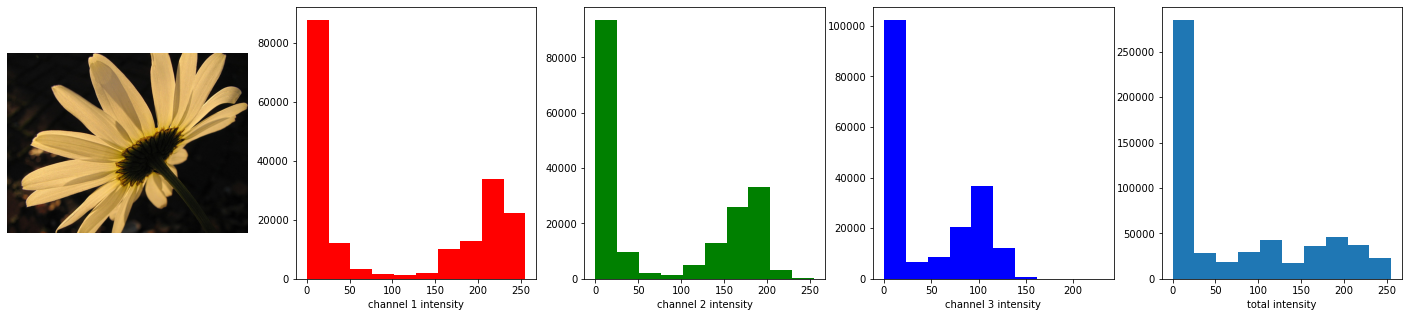

flowers-recognition/flowers/sunflower/18237215308_a158d49f28_n.jpg
Shape: (240, 320, 3)


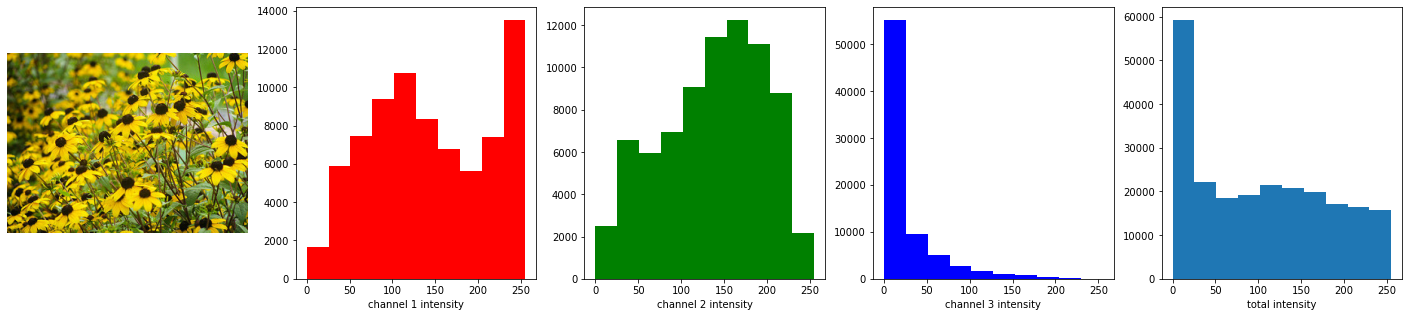

flowers-recognition/flowers/dandelion/136011860_44ca0b2835_n.jpg
Shape: (240, 320, 3)


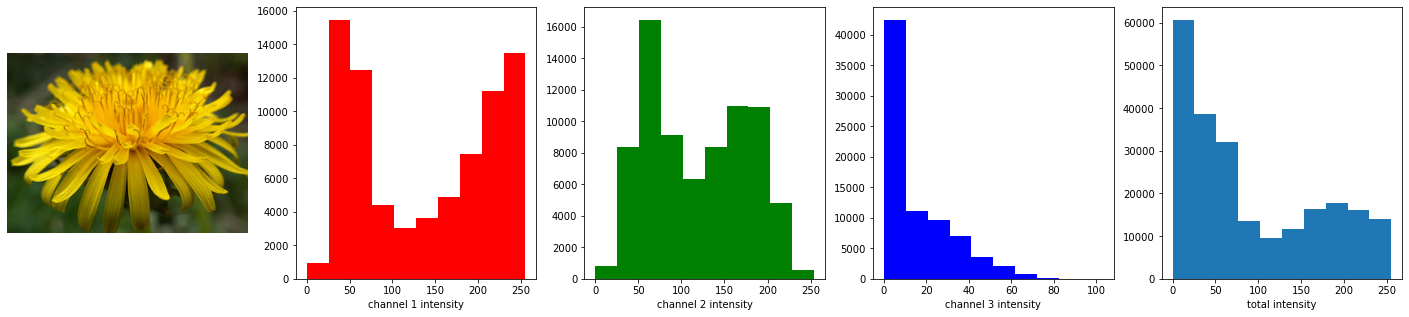

In [7]:
for cl in classes:
    example_path = paths_dict[cl][0]
    print(example_path)
    img = mimg.imread(example_path)
    print('Shape:', img.shape)

    plt.figure(figsize=(25, 5))
    plt.subplot(1, 5, 1)
    plt.imshow(img)
    plt.axis('off')

    for i, color in enumerate(['red', 'green', 'blue']):
        hist = plt.subplot(1, 5, i + 2)
        hist.set_xlabel(f'channel {i + 1} intensity')
        plt.hist(img[:, :, i].flatten(), bins=10, color=color)

    hist = plt.subplot(1, 5, 5)
    hist.set_xlabel(f'total intensity')
    plt.hist(img.flatten(), bins=10)
    plt.show()

Images are not normalized by shape and seems like by color too

### Set up the seed

In [8]:
RANDOM_SEED = 27

In [9]:
import random
import numpy as np
import torch
import pytorch_lightning as pl

In [10]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.determinstic = True
        torch.backends.cudnn.benchmark = False
    # probably the previous steps are not necessary, but I was just being safe.
    pl.seed_everything(seed)


set_seed(RANDOM_SEED)

Global seed set to 27


In [11]:
import pandas as pd

In [12]:
paths_df = pd.DataFrame().from_dict(paths_dict, orient='index').T.stack().reset_index()
paths_df.columns = ['to_drop', 'class', 'path']
paths_df = paths_df[['class', 'path']]
paths_df

class                                               path
0         tulip  flowers-recognition/flowers/tulip/8708209606_d...
1          rose  flowers-recognition/flowers/rose/2777518561_10...
2         daisy  flowers-recognition/flowers/daisy/305160642_53...
3     sunflower  flowers-recognition/flowers/sunflower/18237215...
4     dandelion  flowers-recognition/flowers/dandelion/13601186...
...         ...                                                ...
4312  dandelion  flowers-recognition/flowers/dandelion/26741762...
4313  dandelion  flowers-recognition/flowers/dandelion/24808536...
4314  dandelion  flowers-recognition/flowers/dandelion/16744522...
4315  dandelion  flowers-recognition/flowers/dandelion/56285151...
4316  dandelion  flowers-recognition/flowers/dandelion/14053184...

[4317 rows x 2 columns]

## Splits

In [13]:
from sklearn.model_selection import train_test_split

# Review
it is good that you have shown the importance of checking the split

In [14]:
total_sz = paths_df.shape[0]
train_sz, val_sz, test_sz = int(0.7 * total_sz), int(0.1 * total_sz), int(0.2 * total_sz)

paths_df['is_train'] = False
paths_df['is_val'] = False
paths_df['is_test'] = False

train_val_ix, test_ix = train_test_split(paths_df.index, test_size=test_sz,
                                         random_state=RANDOM_SEED, stratify=paths_df['class'])

paths_df.loc[test_ix, 'is_test'] = True

train_ix, val_ix = train_test_split(paths_df.loc[train_val_ix].index, test_size=val_sz,
                                    random_state=RANDOM_SEED, stratify=paths_df.loc[train_val_ix, 'class'])

paths_df.loc[train_ix, 'is_train'] = True
paths_df.loc[val_ix, 'is_val'] = True

paths_df

class                                               path  is_train  \
0         tulip  flowers-recognition/flowers/tulip/8708209606_d...      True   
1          rose  flowers-recognition/flowers/rose/2777518561_10...     False   
2         daisy  flowers-recognition/flowers/daisy/305160642_53...      True   
3     sunflower  flowers-recognition/flowers/sunflower/18237215...      True   
4     dandelion  flowers-recognition/flowers/dandelion/13601186...      True   
...         ...                                                ...       ...   
4312  dandelion  flowers-recognition/flowers/dandelion/26741762...      True   
4313  dandelion  flowers-recognition/flowers/dandelion/24808536...     False   
4314  dandelion  flowers-recognition/flowers/dandelion/16744522...     False   
4315  dandelion  flowers-recognition/flowers/dandelion/56285151...      True   
4316  dandelion  flowers-recognition/flowers/dandelion/14053184...      True   

      is_val  is_test  
0      False    False  
1      False     True  
2      False    False  
3      False    False  
4      False    False  
...      ...      ...  
4312   False    False  
4313   False     True  
4314    True    False  
4315   False    False  
4316   False    False  

[4317 rows x 5 columns]

Let's check that the split is correct

In [15]:
# each sample should be at most in one split, better exactly in one
splits = ['is_train', 'is_val', 'is_test']
paths_df[splits].sum(axis=1).describe().to_frame().T

count  mean  std  min  25%  50%  75%  max
0  4317.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0

In [16]:
# proportions of the splits correspond to the planned 70-10-20 pct
split_ratio = paths_df[splits].sum(axis=0)
split_ratio = split_ratio / split_ratio.sum()
split_ratio.to_frame().T

is_train    is_val   is_test
0  0.700255  0.099838  0.199907

In [17]:
# proportions of the classes within the splits are preserved
class_ratios = paths_df.groupby('class')[splits].sum()
class_ratios = (class_ratios / class_ratios.sum()).T
class_ratios

class        daisy  dandelion      rose  sunflower     tulip
is_train  0.176977   0.243798  0.181608   0.169699  0.227919
is_val    0.176334   0.243619  0.180974   0.171694  0.227378
is_test   0.177289   0.243337  0.181924   0.169177  0.228273

In [18]:
class_ratios.agg(['mean', 'std'])

class     daisy  dandelion      rose  sunflower     tulip
mean   0.176866   0.243585  0.181502   0.170190  0.227857
std    0.000487   0.000232  0.000483   0.001328  0.000451

# Review

Better to write Pytorch Dataset rather than move files

Now I will move pictures according to splits

In [19]:
from shutil import copyfile, rmtree

In [20]:
splits_path = data_root_path.parent / 'split'

# delete all previously made splits if exists
if os.path.exists(splits_path):
    rmtree(splits_path)


def distribution_by_folders(x, split_name):
    if x[1]:
        class_name = x[0].parent.name
        new_path_folder = splits_path / split_name / class_name
        os.makedirs(new_path_folder, exist_ok=True)
        file_name = x[0].name
        new_path_file = new_path_folder / file_name
        copyfile(x[0], new_path_file)
        return new_path_file
    else:
        return x[2]


paths_df['new_path'] = None

for split in splits:
    print(split)
    paths_df['new_path'] = paths_df[['path', split, 'new_path']].apply(distribution_by_folders,
                                                                       split_name=split, axis=1)

paths_df

is_train
is_val
is_test


class                                               path  is_train  \
0         tulip  flowers-recognition/flowers/tulip/8708209606_d...      True   
1          rose  flowers-recognition/flowers/rose/2777518561_10...     False   
2         daisy  flowers-recognition/flowers/daisy/305160642_53...      True   
3     sunflower  flowers-recognition/flowers/sunflower/18237215...      True   
4     dandelion  flowers-recognition/flowers/dandelion/13601186...      True   
...         ...                                                ...       ...   
4312  dandelion  flowers-recognition/flowers/dandelion/26741762...      True   
4313  dandelion  flowers-recognition/flowers/dandelion/24808536...     False   
4314  dandelion  flowers-recognition/flowers/dandelion/16744522...     False   
4315  dandelion  flowers-recognition/flowers/dandelion/56285151...      True   
4316  dandelion  flowers-recognition/flowers/dandelion/14053184...      True   

      is_val  is_test                                           new_path  
0      False    False  flowers-recognition/split/is_train/tulip/87082...  
1      False     True  flowers-recognition/split/is_test/rose/2777518...  
2      False    False  flowers-recognition/split/is_train/daisy/30516...  
3      False    False  flowers-recognition/split/is_train/sunflower/1...  
4      False    False  flowers-recognition/split/is_train/dandelion/1...  
...      ...      ...                                                ...  
4312   False    False  flowers-recognition/split/is_train/dandelion/2...  
4313   False     True  flowers-recognition/split/is_test/dandelion/24...  
4314    True    False  flowers-recognition/split/is_val/dandelion/167...  
4315   False    False  flowers-recognition/split/is_train/dandelion/5...  
4316   False    False  flowers-recognition/split/is_train/dandelion/1...  

[4317 rows x 6 columns]

# Step 2. Pipeline

In [21]:
def get_channel_mean_std():
    sums = [0, 0, 0]
    counts = [0, 0, 0]
    shape0 = []
    shape1 = []
    for path in paths_df.loc[paths_df['is_train'], 'new_path']:
        img = mimg.imread(path) / 255.0
        shape0.append(img.shape[0])
        shape1.append(img.shape[1])
        for channel in range(3):
            c = img[:, :, channel].flatten()
            sums[channel] += c.sum()
            counts[channel] += c.shape[0]

    MEAN = np.array(sums) / np.array(counts)
    print(f'train MEAN: {MEAN}')

    sum_sqr = [0, 0, 0]
    for path in paths_df.loc[paths_df['is_train'], 'new_path']:
        img = mimg.imread(path) / 255.0
        for channel in range(3):
            c = img[:, :, channel].flatten()
            sum_sqr[channel] += np.square(c - MEAN[channel]).sum()

    STD = np.sqrt(np.array(sum_sqr) / np.array(counts))
    print(f'train STD: {STD}')

    plt.figure(figsize=(10, 5))
    for i, shape in enumerate([shape0, shape1]):
        hist = plt.subplot(1, 2, i + 1)
        hist.set_xlabel(f'shapes {i} hist')
        plt.hist(shape, bins=10)
    plt.show()

    print(f'shapes median {(np.median(shape0), np.median(shape1))}')
    return MEAN, STD

I'm not sure that measure the mean and std on images with the original dimensions better or worse than on reshaped ones, but I hope that this is not very important, may be check it later. 

# Review
You are right it isn't important here

In [22]:
# MEAN, STD = get_channel_mean_std()
MEAN = [0.46088175, 0.41973322, 0.30123084]
STD = [0.3003363, 0.26977545, 0.29235746]

In [23]:
import torchvision.transforms as T

# Review
Better to use Albumentation

In [24]:

aug_transforms = [
    #                   T.RandomAutocontrast(),
    T.RandomHorizontalFlip(),
    T.RandomRotation(30),
    T.RandomResizedCrop((256, 256), scale=(0.8, 1.0), ratio=(0.9, 1.1))
]

input_transforms = [T.Resize(256),
                    T.CenterCrop(224),
                    T.ToTensor(),
                    T.Normalize(MEAN, STD)]

TEST_TRANSFORM = T.Compose(input_transforms)
TRAIN_TRANSFORM = T.Compose(aug_transforms + input_transforms)

## Dataloaders
I hope that by *Download data* you meant dataloaders, otherwise, I'm confused, since the data is static and has already been downloaded in the beginning

In [25]:
splits_path

PosixPath('flowers-recognition/split')

In [26]:
os.listdir(splits_path)

['is_train', 'is_val', 'is_test']

In [27]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from imbalanced import ImbalancedDatasetSampler

In [28]:
def create_dataloader(split_name, fix_imbalance=False, batch_size=128, preprocessing=None,
                      num_workers=8, pin_memory=False):
    path = splits_path / split_name
    dataset = ImageFolder(path, transform=preprocessing)

    shuffle = True if 'train' in split_name.lower() else False
    if fix_imbalance:
        weighted_sampler = ImbalancedDatasetSampler(dataset)
        shuffle = False
    else:
        weighted_sampler = None
    dataloader = DataLoader(dataset, batch_size=batch_size,
                            shuffle=shuffle, sampler=weighted_sampler,
                            num_workers=num_workers, pin_memory=pin_memory)
    return dataloader

In [29]:
from torchvision.utils import make_grid

Check if augmentations and sampling looks OK

# Review
Would be great to use  something like the following:
TensorFlow Data Validation: https://www.tensorflow.org/tfx/guide/tfdv
or even: https://knowyourdata.withgoogle.com/docs/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


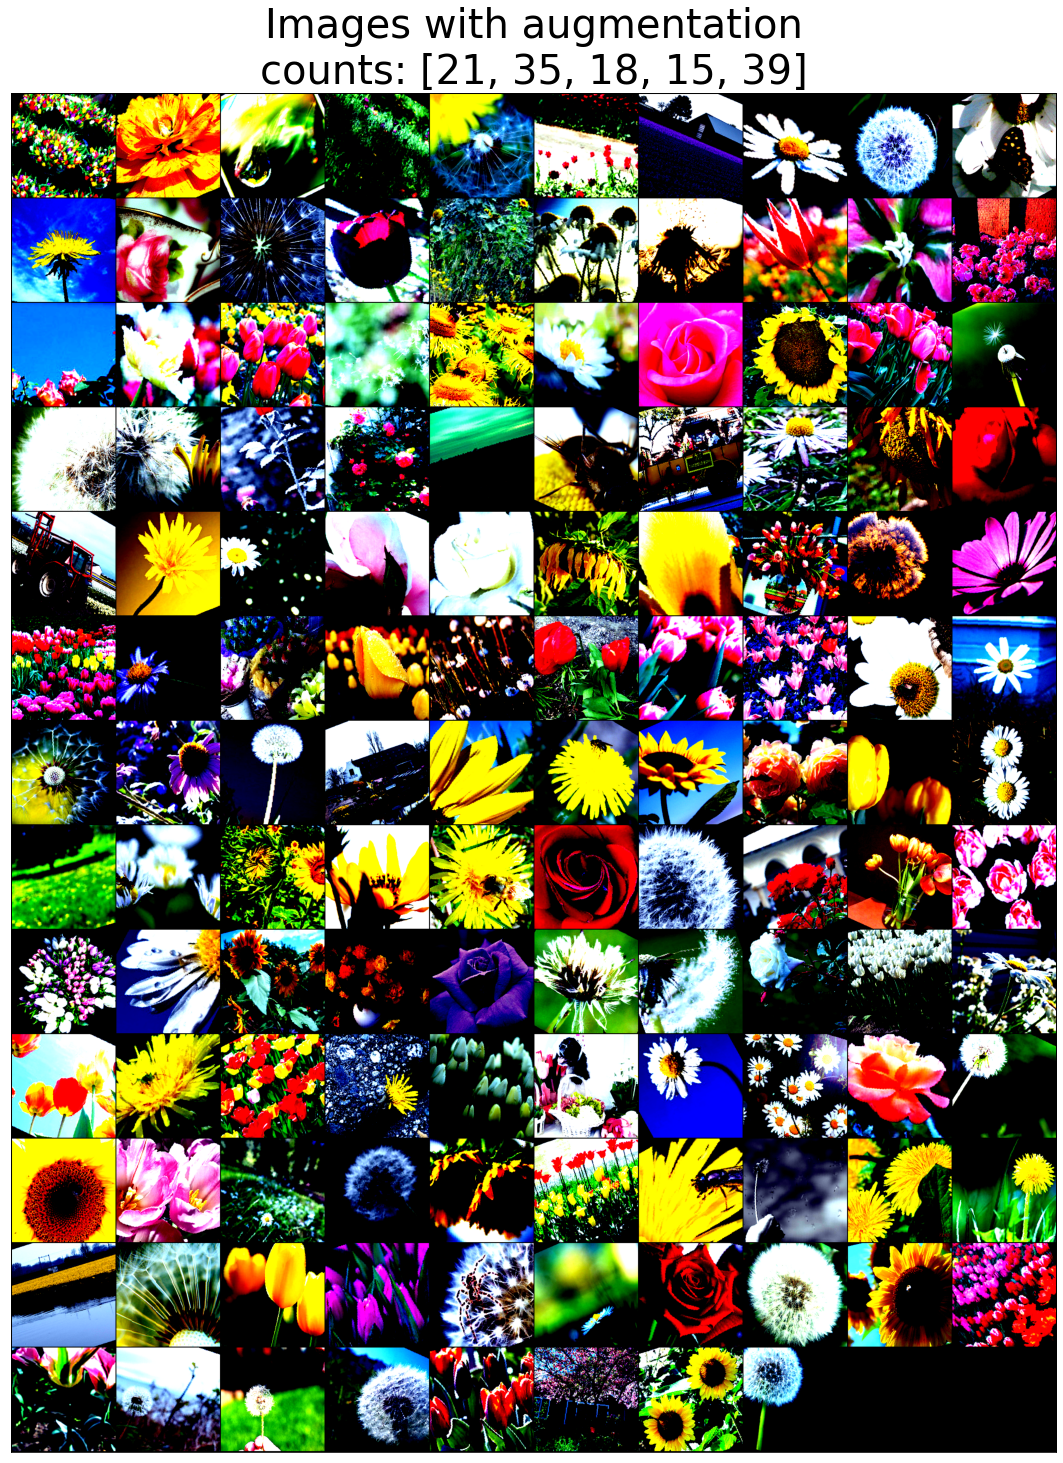

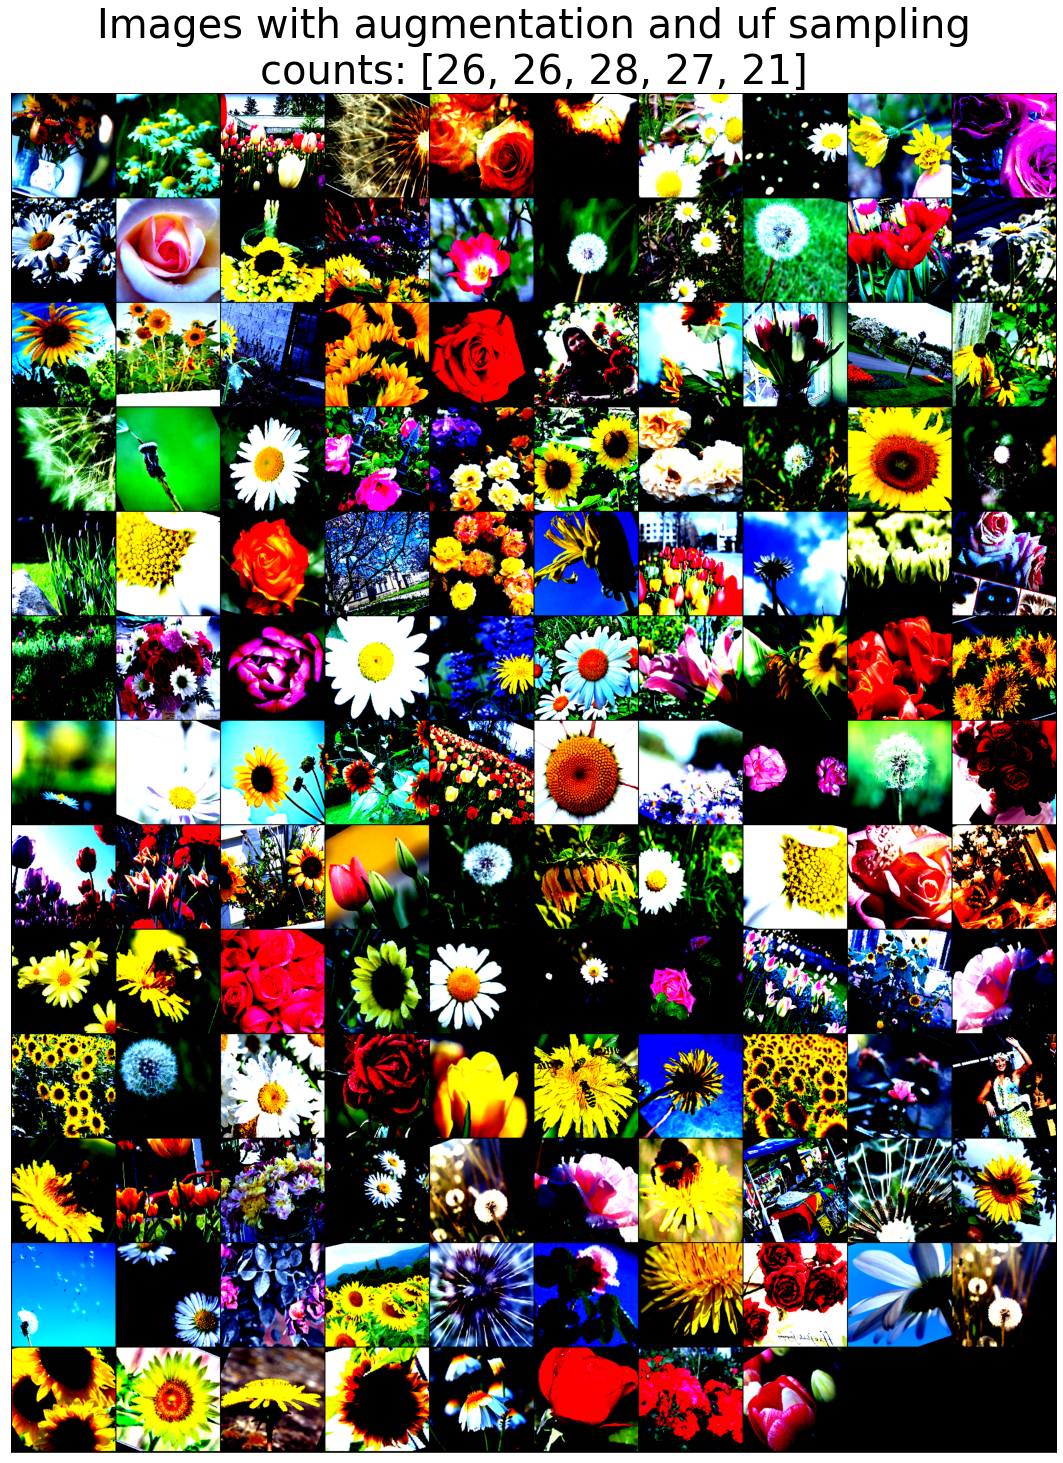

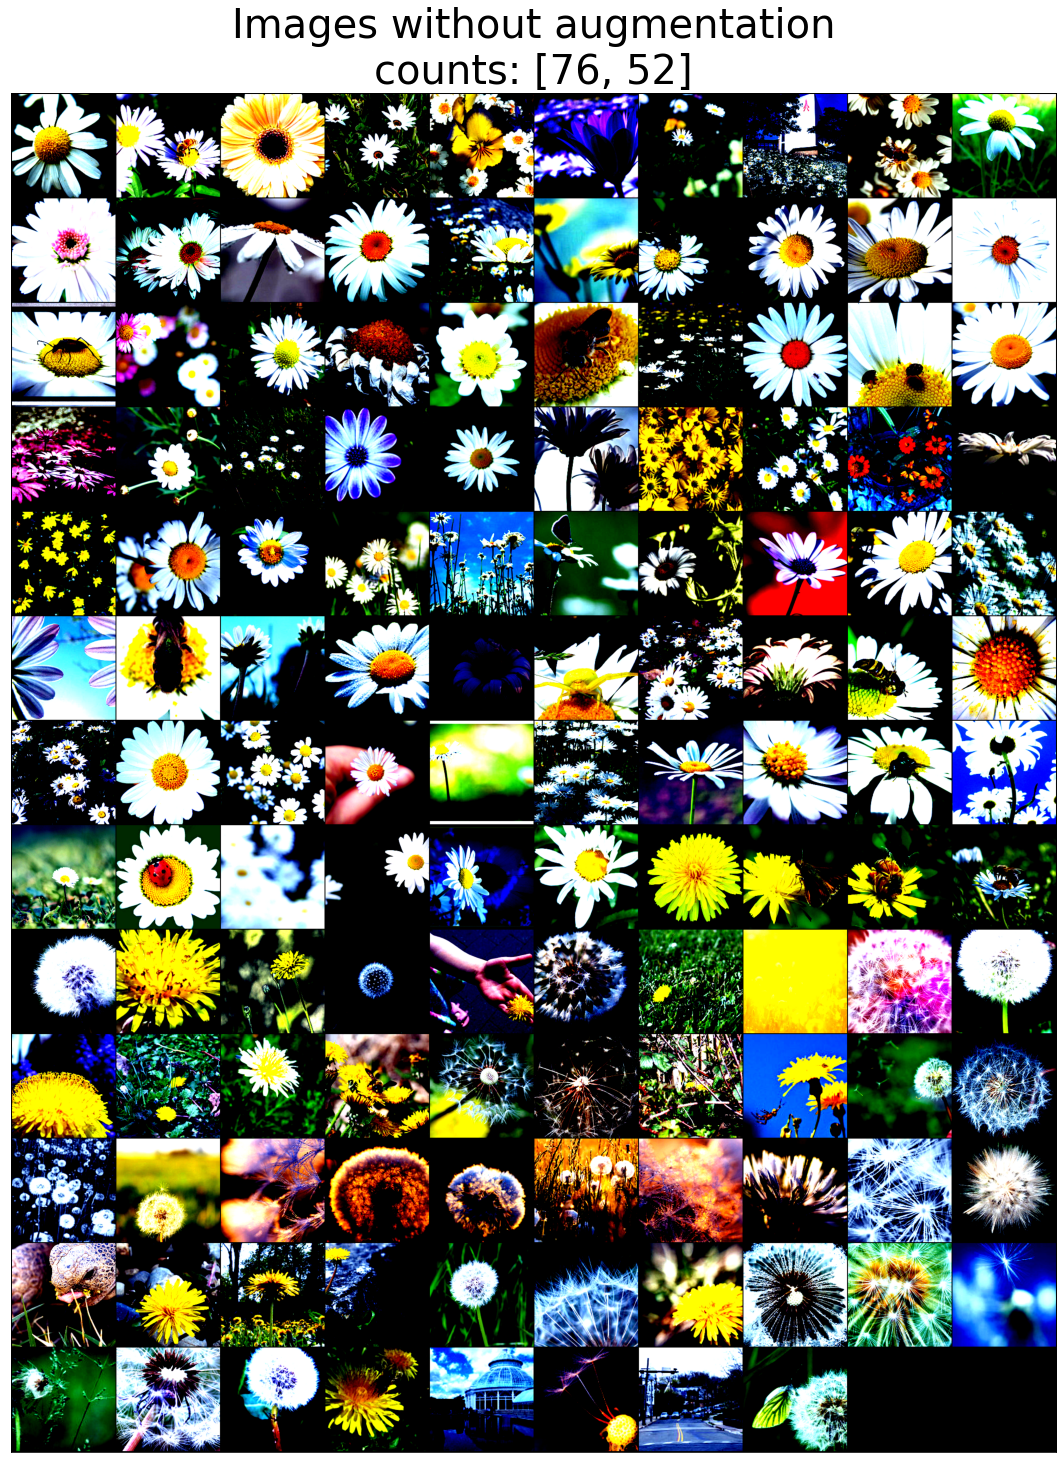

In [30]:

def show_batch(batch, y, title='Images'):
    fig, ax = plt.subplots(figsize=(25, 25))
    ax.set_xticks([]);
    ax.set_yticks([])
    ax.imshow(make_grid(batch, nrow=10).permute(1, 2, 0))
    counts = torch.unique(y, return_counts=True)[1].tolist()
    ax.set_title(title + '\n' + f'counts: {counts}', fontsize=40)


temp = create_dataloader('is_train', preprocessing=TRAIN_TRANSFORM)
x, y = next(iter(temp))
show_batch(x, y, 'Images with augmentation')

temp = create_dataloader('is_train', fix_imbalance=True, preprocessing=TRAIN_TRANSFORM)
x, y = next(iter(temp))
show_batch(x, y, 'Images with augmentation and uf sampling')

temp = create_dataloader('is_val', preprocessing=TEST_TRANSFORM)
x, y = next(iter(temp))
show_batch(x, y, 'Images without augmentation')

# Models

In [31]:
import torch.nn as nn
import torchvision.models as tv_models

In [32]:
def make_classifier(in_features, out_features, simple=True):
    if simple:
        return nn.Linear(in_features, out_features)
    else:
        return nn.Sequential(nn.Linear(in_features, 256),
                             nn.Dropout(0.1),
                             nn.ReLU(),
                             nn.Linear(256, 64),
                             nn.Dropout(0.01),
                             nn.ReLU(),
                             nn.Linear(64, out_features))


def init_model(model_name='resnet50', freeze_base=True, simple=True):
    model = getattr(tv_models, model_name)(pretrained=True)

    if freeze_base:
        for param in model.parameters():
            param.requires_grad = False

    try:
        model.fc = make_classifier(model.fc.in_features, CLASS_NUM, simple)
    except AttributeError:
        model.classifier = make_classifier(model.classifier.in_features, CLASS_NUM, simple)
    return model

as a evaluation metric I prefer mAP

In [33]:
MONITOR = 'val_mAP'

In [34]:
from torchmetrics import AveragePrecision, Accuracy
import torch.optim as optim

# Review
It's good that you use lightning

## Training

In [35]:
class TrainingModule(pl.LightningModule):
    def __init__(self, model_name, optimizer_name, optimizer_hparams,
                 train_preprocess, test_preprocess, simple_classifier=True,
                 scheduler_name=None, scheduler_hparams=None, freeze_base=True,
                 batch_size=128, fix_imbalance=False):
        super().__init__()

        self.save_hyperparameters()
        print(self.hparams)
        self.model = init_model(model_name, freeze_base=True, simple=simple_classifier)
        self.loss_fct = nn.CrossEntropyLoss()
        self.mAP = AveragePrecision(CLASS_NUM, average='macro')
        self.acc = Accuracy(num_classes=CLASS_NUM, average='micro')
        self.optimizer = None

    def forward(self, x):
        return self.model(x)

    def common_step(self, batch):
        imgs, labels = batch
        preds = self.model(imgs)
        acc = self.acc(preds.argmax(dim=-1), labels)
        mAP = self.mAP(preds.softmax(dim=-1), labels)
        loss = self.loss_fct(preds, labels)
        return loss, mAP, acc,

    def training_step(self, batch, batch_nb):
        loss, mAP, acc = self.common_step(batch)
        self.log('train_mAP', mAP, on_step=False, on_epoch=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_nb):
        loss, mAP, acc = self.common_step(batch)
        self.log('val_mAP', mAP)
        self.log('val_acc', acc)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_nb):
        loss, mAP, acc = self.common_step(batch)
        self.log('test_mAP', mAP)
        self.log('test_acc', acc)
        self.log('test_loss', loss)

    def configure_optimizers(self):
        optimizer = getattr(optim, self.hparams.optimizer_name)(
            self.parameters(),
            **self.hparams.optimizer_hparams)

        if self.hparams.scheduler_name is not None:
            scheduler = getattr(optim.lr_scheduler, self.hparams.scheduler_name)(
                optimizer,
                **self.hparams.scheduler_hparams)
            return {'optimizer': optimizer, 'scheduler': scheduler, 'monitor': MONITOR}
        else:
            return {'optimizer': optimizer}

    def train_dataloader(self):
        return create_dataloader('is_train',
                                 self.hparams.fix_imbalance,
                                 self.hparams.batch_size,
                                 self.hparams.train_preprocess)

    def val_dataloader(self):
        return create_dataloader('is_val',
                                 fix_imbalance=False,
                                 batch_size=self.hparams.batch_size,
                                 preprocessing=self.hparams.test_preprocess)

    def test_dataloader(self):
        return create_dataloader('is_test',
                                 fix_imbalance=False,
                                 batch_size=self.hparams.batch_size,
                                 preprocessing=self.hparams.test_preprocess)


### A comparison of models can be found here  
https://wandb.ai/romakoks/prvcts-test  
https://wandb.ai/romakoks/prvcts-test/reports/Shared-panel-21-11-28-17-11-89--VmlldzoxMjc1NDE2  

In [36]:
import wandb

In [37]:
PROJECT_NAME = 'prvcts-test'
# wandb.init(project=PROJECT_NAME, entity="romakoks")

In [38]:
# for p in ['lightning_logs', 'wandb', 'models']:
#     if os.path.exists(p):
#         rmtree(p)

### Definition of hyperparameters

In [41]:
import itertools

In [42]:
PATIENCE = 4
NUM_TRIALS_PER_MODEL = 25

freeze_base = [True, False]
fix_imbalance = [True, False]
simple_classifier = [True, False]
lr = [1e-1, 1e-2, 1e-3]
weight_decay = [1e-4, 0]
optimizer_name = ['AdamW', 'SGD']
scheduler = [('ReduceLROnPlateau', {'patience': PATIENCE // 2}),
             ('MultiStepLR', {'milestones': [6, 25]}),
             (None, None)]

p_space = [
    freeze_base,
    fix_imbalance,
    simple_classifier,
    lr,
    weight_decay,
    optimizer_name,
    scheduler
]

p_space = np.array(list(itertools.product(*p_space)), dtype=object)
print(f'params space size: {p_space.shape[0]}')
p_space = p_space[np.random.choice(p_space.shape[0], NUM_TRIALS_PER_MODEL, replace=False)]
print(f'trials number per model: {p_space.shape[0]}')

params space size: 288
trials number per model: 25


### Running experiments and logging in W&B

In [39]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger

# Review
A simple and elegant way of using Wandb, but would be good to log model artifacts

In [ ]:
for p_set in p_space:
    for model_name in ['resnet50', 'googlenet', 'densenet121']:
        freeze_base, fix_imbalance, simple_classifier, lr, weight_decay, optimizer_name, scheduler = p_set
        optimizer = (optimizer_name, {"lr": lr, 'weight_decay': weight_decay})
        prefix = f'{model_name}_{optimizer_name}_{scheduler[0]}_'
        prefix += f'fb={freeze_base}_fi={fix_imbalance}_sc={simple_classifier}_lr={lr}_wd={weight_decay}'
        if optimizer[0] == 'SGD':
            optimizer[1]['momentum'] = np.random.choice([0, 0.1, 0.9], 1)[0]
            prefix += f"_m={optimizer[1]['momentum']}"
        set_seed(RANDOM_SEED)
        trainer = pl.Trainer(gpus=[0], max_epochs=50,
                             logger=WandbLogger(project=PROJECT_NAME),
                             enable_progress_bar=False,
                             enable_model_summary=False,
                             callbacks=[EarlyStopping(monitor=MONITOR,
                                                      min_delta=0.00,
                                                      patience=PATIENCE,
                                                      verbose=True,
                                                      mode='max'),
                                        ModelCheckpoint(f'models/{prefix}',
                                                        '{val_mAP:.6f}-{val_acc:.4f}-{epoch}',
                                                        monitor='val_mAP'),
                                        LearningRateMonitor("epoch"),
                                        ],
                             log_every_n_steps=24)
        module = TrainingModule(model_name=model_name,
                                optimizer_name=optimizer[0],
                                optimizer_hparams=optimizer[1],
                                freeze_base=freeze_base,
                                simple_classifier=simple_classifier,
                                fix_imbalance=fix_imbalance,
                                scheduler_name=scheduler[0],
                                scheduler_hparams=scheduler[1],
                                train_preprocess=TRAIN_TRANSFORM,
                                test_preprocess=TEST_TRANSFORM)
        trainer.fit(module)
        trainer.test()
        wandb.finish()

The code is good overall. I very appreciated to your efforts. I will provide my feedback to HR and she is getting touch with you.
There was a misunderstanding, I will take it into account and change the description in the future.
I expected the training/learning pipeline to be based on Sagemaker pipelines, sklearn pipelines, MLflow, etc.